**Tracking and Analyzing NYC Shooting Incidents**

In [22]:
import pandas as pd

# Dataset
df = pd.read_csv('/content/NYPD_Shooting_Incident_Data__Year_To_Date__20250326.csv')

# Displaying the first few rows to understand the dataset
print(df.head())

# Checking for missing values
print(df.isnull().sum())

# Checking unique values in categorical columns to understand their distribution
print(df['PERP_RACE'].unique())
print(df['VIC_RACE'].unique())


   INCIDENT_KEY  OCCUR_DATE OCCUR_TIME      BORO LOC_OF_OCCUR_DESC  PRECINCT  \
0     288208649  06/08/2024    3:00:00    QUEENS           OUTSIDE       110   
1     283404608  03/07/2024   16:14:00     BRONX           OUTSIDE        40   
2     281486708  02/01/2024    8:17:00    QUEENS           OUTSIDE       113   
3     280179979  01/08/2024   18:30:00  BROOKLYN           OUTSIDE        79   
4     289111780  06/25/2024   23:45:00     BRONX           OUTSIDE        42   

   JURISDICTION_CODE LOC_CLASSFCTN_DESC              LOCATION_DESC  \
0                  0             STREET                     (null)   
1                  0             STREET                     (null)   
2                  0         COMMERCIAL             BAR/NIGHT CLUB   
3                  2            HOUSING  MULTI DWELL - PUBLIC HOUS   
4                  0             STREET                     (null)   

  STATISTICAL_MURDER_FLAG  ... PERP_SEX       PERP_RACE VIC_AGE_GROUP VIC_SEX  \
0                

**Data Cleaning and Preprocessing**

In [6]:
# Droping rows where Latitude, Longitude, or New Georeferenced Column are NaN
df_cleaned = df.dropna(subset=['Latitude', 'Longitude', 'New Georeferenced Column'])

# Alternatively, you can choose to fill missing geospatial data with a default value (e.g., 0)
# df['Latitude'].fillna(0, inplace=True)
# df['Longitude'].fillna(0, inplace=True)
# df['New Georeferenced Column'].fillna("Unknown", inplace=True)

# Checking if there are still missing values
print(df_cleaned.isnull().sum())


INCIDENT_KEY                0
OCCUR_DATE                  0
OCCUR_TIME                  0
BORO                        0
LOC_OF_OCCUR_DESC           0
PRECINCT                    0
JURISDICTION_CODE           0
LOC_CLASSFCTN_DESC          0
LOCATION_DESC               0
STATISTICAL_MURDER_FLAG     0
PERP_AGE_GROUP              0
PERP_SEX                    0
PERP_RACE                   0
VIC_AGE_GROUP               0
VIC_SEX                     0
VIC_RACE                    0
X_COORD_CD                  0
Y_COORD_CD                  0
Latitude                    0
Longitude                   0
New Georeferenced Column    0
dtype: int64


**Clean Categorical Columns**

In [7]:
# Replacing '(null)' with actual NaN values
df_cleaned['PERP_RACE'] = df_cleaned['PERP_RACE'].replace('(null)', pd.NA)
df_cleaned['VIC_RACE'] = df_cleaned['VIC_RACE'].replace('(null)', pd.NA)

# Optionally, we can fill missing race data with the mode (most frequent value) for simplicity
df_cleaned['PERP_RACE'].fillna(df_cleaned['PERP_RACE'].mode()[0], inplace=True)
df_cleaned['VIC_RACE'].fillna(df_cleaned['VIC_RACE'].mode()[0], inplace=True)

# Encoding categorical variables (e.g., PERP_RACE, VIC_RACE, and others)
df_cleaned['BORO'] = df_cleaned['BORO'].astype('category').cat.codes
df_cleaned['PERP_SEX'] = df_cleaned['PERP_SEX'].astype('category').cat.codes
df_cleaned['PERP_RACE'] = df_cleaned['PERP_RACE'].astype('category').cat.codes
df_cleaned['VIC_SEX'] = df_cleaned['VIC_SEX'].astype('category').cat.codes
df_cleaned['VIC_RACE'] = df_cleaned['VIC_RACE'].astype('category').cat.codes

# Encoding the target variable STATISTICAL_MURDER_FLAG (Y/N -> 1/0)
df_cleaned['STATISTICAL_MURDER_FLAG'] = df_cleaned['STATISTICAL_MURDER_FLAG'].apply(lambda x: 1 if x == 'Y' else 0)

# Checking cleaned data
print(df_cleaned.head())


    INCIDENT_KEY  OCCUR_DATE OCCUR_TIME  BORO LOC_OF_OCCUR_DESC  PRECINCT  \
7      290044415  07/13/2024    1:00:00     2           OUTSIDE        32   
8      287507794  05/24/2024    0:14:00     0           OUTSIDE        52   
9      285259765  04/12/2024   16:50:00     1           OUTSIDE        75   
10     289469889  07/02/2024   19:45:00     0           OUTSIDE        52   
11     290420710  07/21/2024   22:51:00     1           OUTSIDE        88   

    JURISDICTION_CODE LOC_CLASSFCTN_DESC              LOCATION_DESC  \
7                   0             STREET                     (null)   
8                   0             STREET                     (null)   
9                   2            HOUSING  MULTI DWELL - PUBLIC HOUS   
10                  0             STREET                     (null)   
11                  0             STREET                     (null)   

    STATISTICAL_MURDER_FLAG  ... PERP_SEX  PERP_RACE  VIC_AGE_GROUP VIC_SEX  \
7                         1  ..

<ipython-input-7-edfe49511cac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['PERP_RACE'] = df_cleaned['PERP_RACE'].replace('(null)', pd.NA)
<ipython-input-7-edfe49511cac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['VIC_RACE'] = df_cleaned['VIC_RACE'].replace('(null)', pd.NA)
<ipython-input-7-edfe49511cac>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. 

**Feature Engineering**

In [8]:
# Example: Creating a new feature 'Time_of_Day' based on OCCUR_TIME
df_cleaned['OCCUR_TIME'] = pd.to_datetime(df_cleaned['OCCUR_TIME'], format='%H:%M:%S').dt.time

def get_time_of_day(time):
    if 6 <= time.hour < 12:
        return 'Morning'
    elif 12 <= time.hour < 18:
        return 'Afternoon'
    elif 18 <= time.hour < 24:
        return 'Evening'
    else:
        return 'Night'

df_cleaned['Time_of_Day'] = df_cleaned['OCCUR_TIME'].apply(get_time_of_day)

# Example: Creating a binary feature indicating whether the victim and perpetrator are from the same age group
df_cleaned['Same_Age_Group'] = (df_cleaned['PERP_AGE_GROUP'] == df_cleaned['VIC_AGE_GROUP']).astype(int)

# Check feature engineering results
print(df_cleaned[['PERP_AGE_GROUP', 'VIC_AGE_GROUP', 'Time_of_Day', 'Same_Age_Group']].head())


   PERP_AGE_GROUP VIC_AGE_GROUP Time_of_Day  Same_Age_Group
7           25-44         18-24       Night               0
8           18-24         25-44       Night               0
9           18-24         25-44   Afternoon               0
10         (null)         25-44     Evening               0
11          25-44         45-64     Evening               0


<ipython-input-8-7a248401a34e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['OCCUR_TIME'] = pd.to_datetime(df_cleaned['OCCUR_TIME'], format='%H:%M:%S').dt.time
<ipython-input-8-7a248401a34e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Time_of_Day'] = df_cleaned['OCCUR_TIME'].apply(get_time_of_day)
<ipython-input-8-7a248401a34e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

**Exploratory Data Analysis (EDA)**

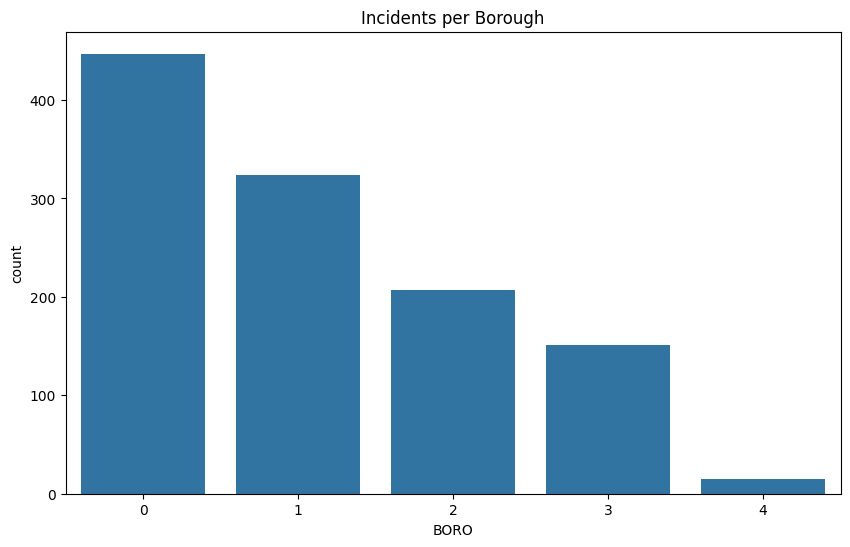

<ipython-input-10-a7123cedab1f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='VIC_AGE_GROUP', data=df_cleaned, palette='viridis')


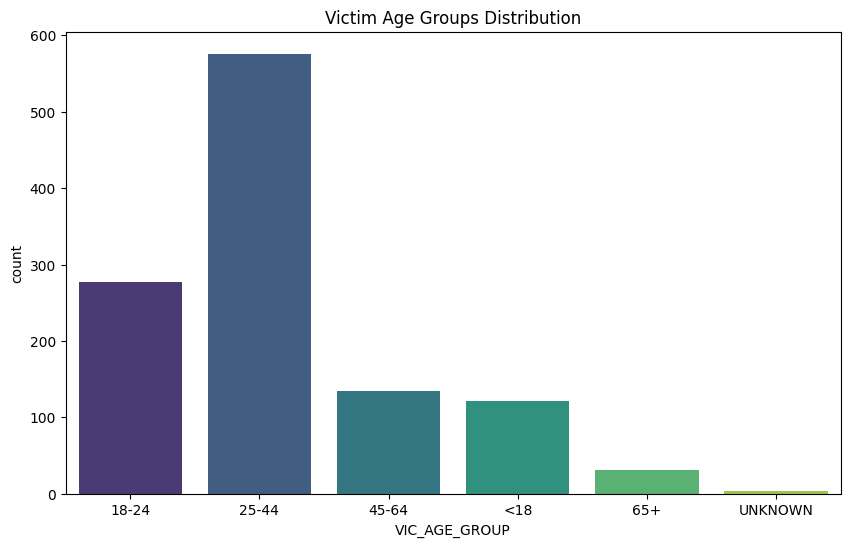

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Countplot for incidents by borough
plt.figure(figsize=(10, 6))
sns.countplot(x='BORO', data=df_cleaned)
plt.title('Incidents per Borough')
plt.show()

# Distribution of age groups of victims and perpetrators
plt.figure(figsize=(10, 6))
sns.countplot(x='VIC_AGE_GROUP', data=df_cleaned, palette='viridis')
plt.title('Victim Age Groups Distribution')
plt.show()



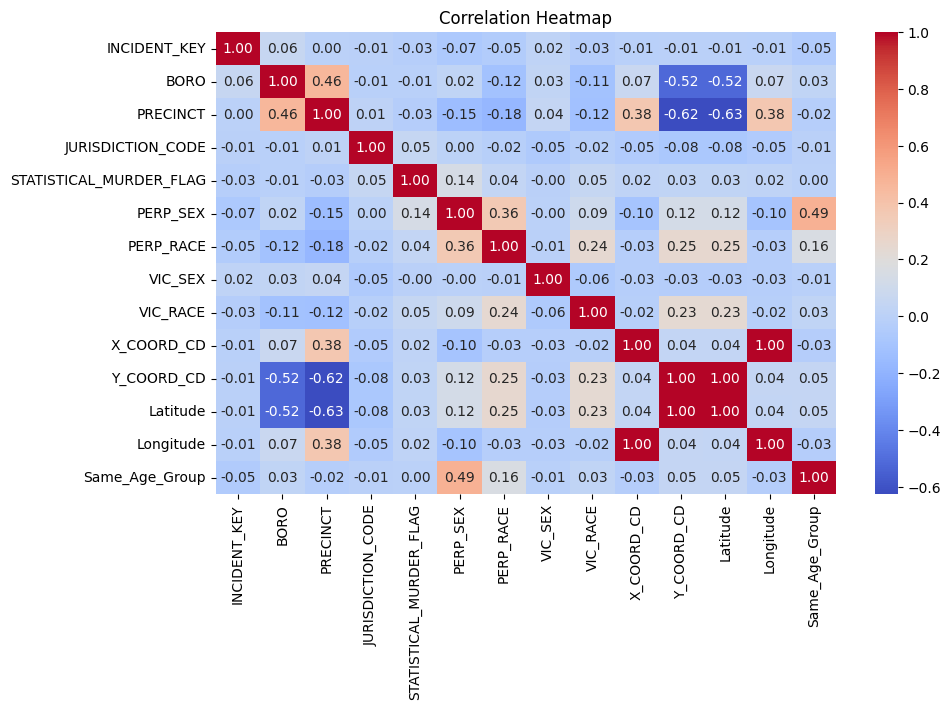

In [11]:
# Select only numeric columns for correlation matrix
df_numeric = df_cleaned.select_dtypes(include=['number'])

# Calculate and plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


<ipython-input-17-9a5e02b02577>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='LOC_CLASSFCTN_DESC', data=df_cleaned, palette='plasma')


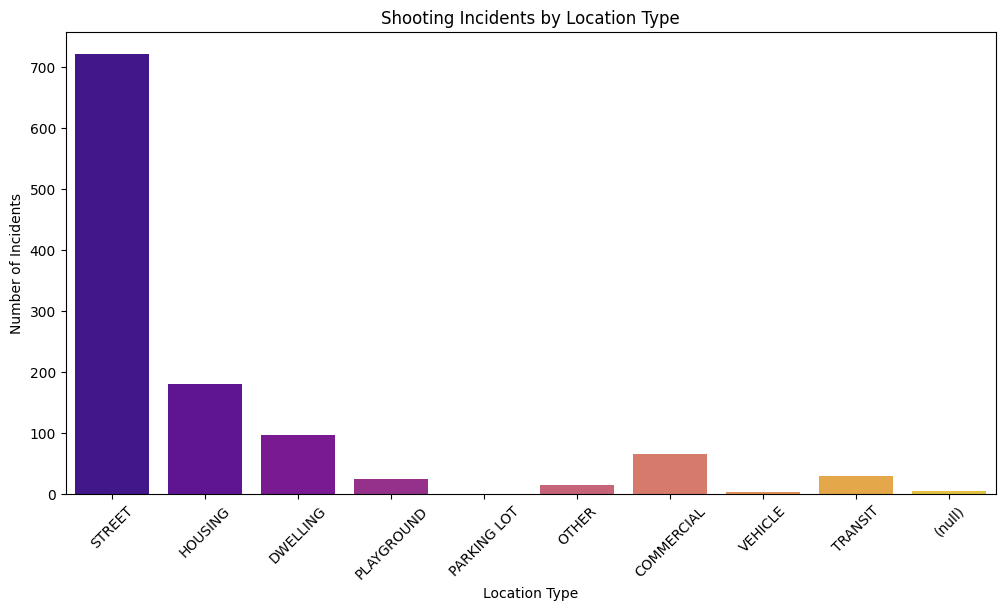

In [17]:
# Ploting shooting incidents by location type
plt.figure(figsize=(12, 6))
sns.countplot(x='LOC_CLASSFCTN_DESC', data=df_cleaned, palette='plasma')
plt.title('Shooting Incidents by Location Type')
plt.xlabel('Location Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()


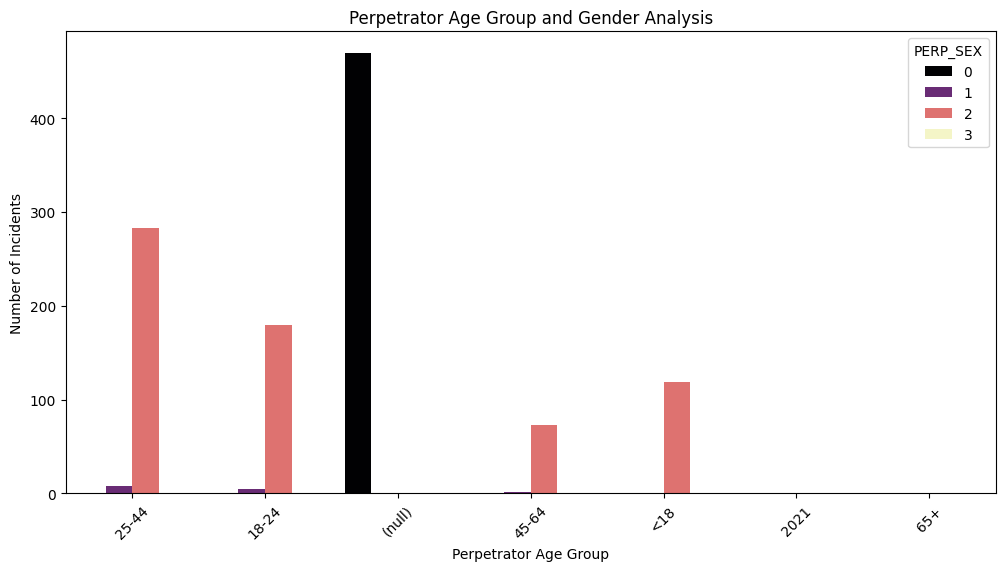

In [18]:
# Ploting perpetrator age group and gender
plt.figure(figsize=(12, 6))
sns.countplot(x='PERP_AGE_GROUP', hue='PERP_SEX', data=df_cleaned, palette='magma')
plt.title('Perpetrator Age Group and Gender Analysis')
plt.xlabel('Perpetrator Age Group')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()


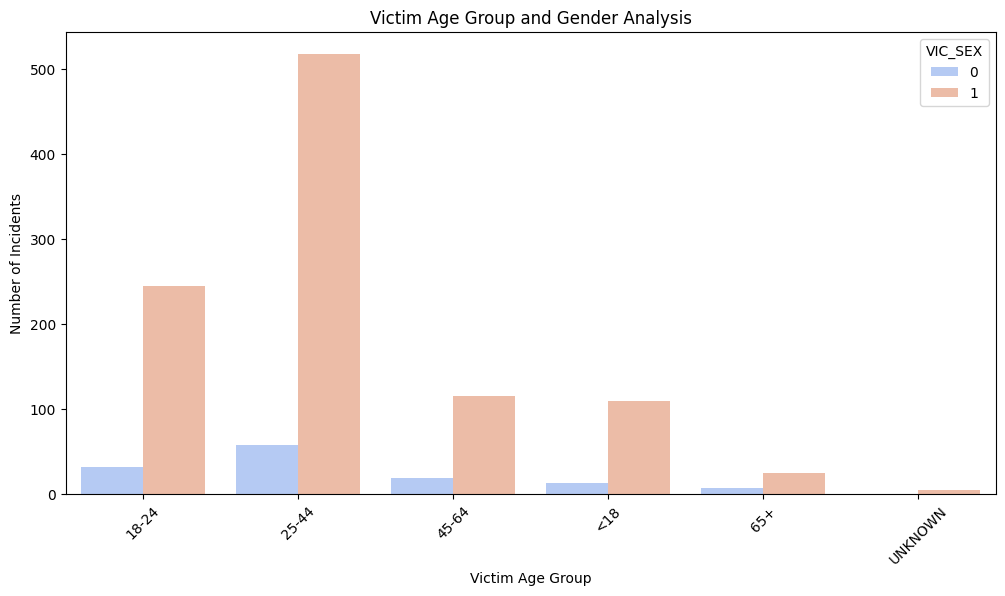

<ipython-input-19-d2ebae74de87>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='VIC_RACE', data=df_cleaned, palette='Set3')


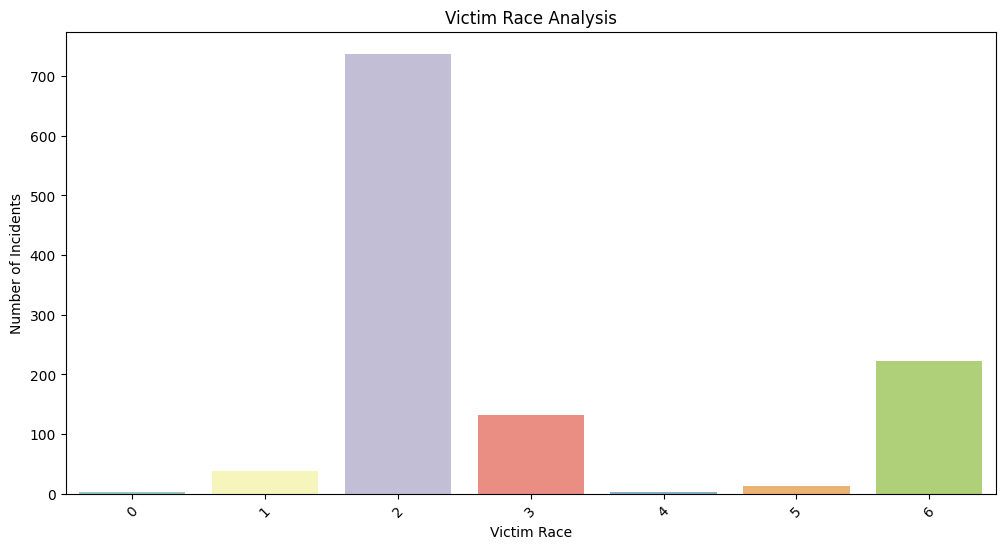

In [19]:
# Ploting victim age group and gender
plt.figure(figsize=(12, 6))
sns.countplot(x='VIC_AGE_GROUP', hue='VIC_SEX', data=df_cleaned, palette='coolwarm')
plt.title('Victim Age Group and Gender Analysis')
plt.xlabel('Victim Age Group')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()

# Ploting victim race
plt.figure(figsize=(12, 6))
sns.countplot(x='VIC_RACE', data=df_cleaned, palette='Set3')
plt.title('Victim Race Analysis')
plt.xlabel('Victim Race')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.show()


<ipython-input-20-a6fd5792f8ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['OCCUR_HOUR'] = pd.to_datetime(df_cleaned['OCCUR_TIME'], format='%H:%M:%S').dt.hour
<ipython-input-20-a6fd5792f8ef>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='OCCUR_HOUR', data=df_cleaned, palette='coolwarm')


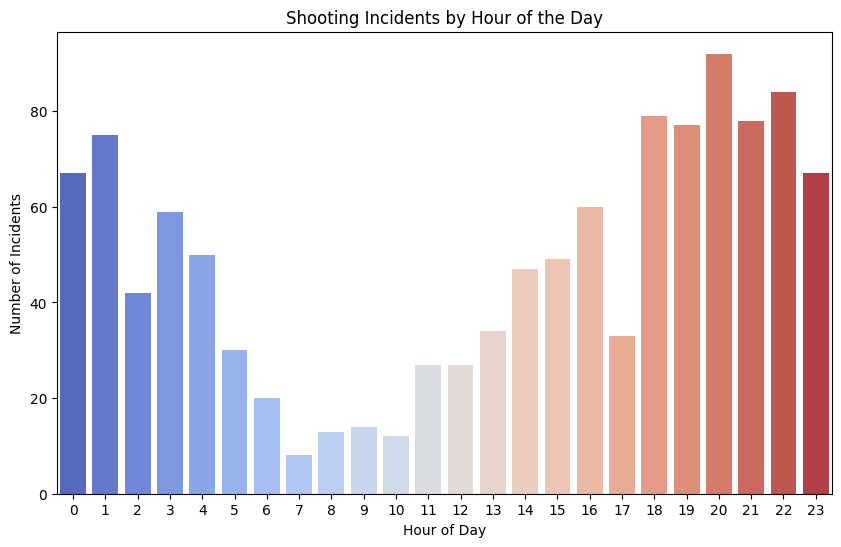

In [20]:
# Extracting hour from OCCUR_TIME
df_cleaned['OCCUR_HOUR'] = pd.to_datetime(df_cleaned['OCCUR_TIME'], format='%H:%M:%S').dt.hour

# Ploting shooting incidents by hour of the day
plt.figure(figsize=(10, 6))
sns.countplot(x='OCCUR_HOUR', data=df_cleaned, palette='coolwarm')
plt.title('Shooting Incidents by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Incidents')
plt.show()


**Building a Predictive Model**

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Defining features (X) and target (y)
X = df_cleaned[['PERP_AGE_GROUP', 'VIC_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'VIC_SEX', 'VIC_RACE', 'BORO', 'Time_of_Day']]
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding for categorical variables

y = df_cleaned['STATISTICAL_MURDER_FLAG']

# Spliting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initializing and train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Accuracy: 0.7383720930232558
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       274
           1       0.19      0.09      0.12        70

    accuracy                           0.74       344
   macro avg       0.49      0.50      0.48       344
weighted avg       0.67      0.74      0.70       344

Confusion Matrix:
 [[248  26]
 [ 64   6]]


**Model Evaluation and Interpretation**

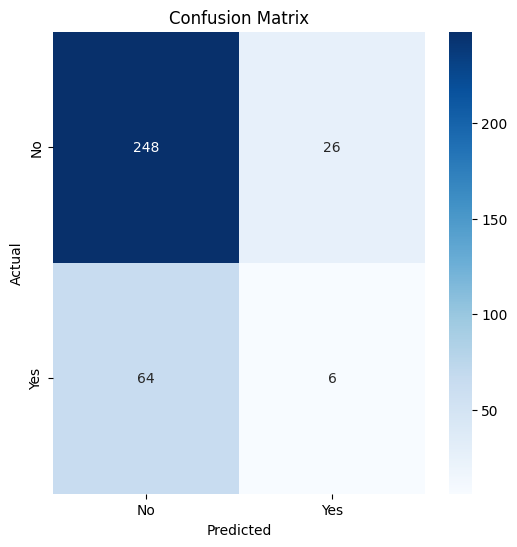

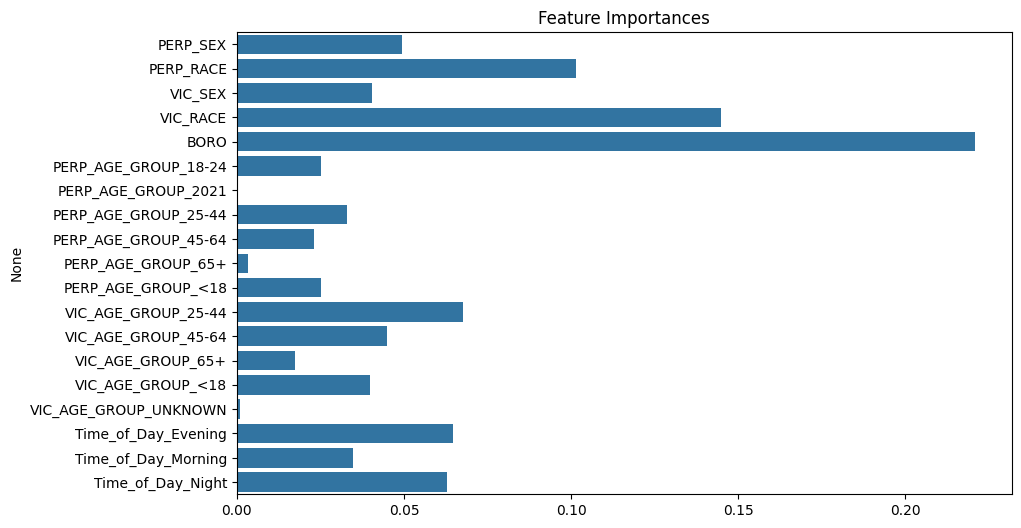

In [13]:
# Ploting confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Featuring importance from the Random Forest model
importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.show()


Interpreting the Values:
0.00: This means that the feature has no contribution to the model's predictions, implying that this feature is not useful in distinguishing the target variable in the model.

0.05, 0.10, 0.20: These values represent the relative importance of each feature. A feature with an importance of 0.20 is more influential in predicting the target variable than one with an importance of 0.05.

For example:

If a feature has an importance of 0.20, it contributes 20% of the predictive power for the target variable.

If a feature has an importance of 0.05, it contributes only 5% of the predictive power.